# Integrated Workflow for Predictive Maintenance Classification

**Author:** Paula Schultz (CDS 303 - Team 4)
**Date:** March 2025

---

## Project Goal

Develop and evaluate an integrated machine learning workflow for classifying machine failure (`Bool_MF`) based on sensor data. This notebook focuses on memory optimization, reducing model overfitting, and leveraging GPU acceleration for XGBoost.

---

## Development Notes

Methods to develop code were iterative ChatGPT o3-mini-high usage until that ran out, and then using Gemini 2.5 Pro. Converted to Jupyter Notebook after majority of functions developed in Spyder.

---

## Workflow Overview

1.  **Load & Prepare Data:** Load `full_normalized.csv`, selecting only necessary features (`norm_power`, `norm_temp_diff`, `norm_tool_wear_adjusted`, `Bool_MF`) with memory-optimized data types.
2.  **Exploratory Data Analysis (EDA):** Analyze feature correlations using a heatmap.
3.  **Model Training & Evaluation:** Train and evaluate three distinct classifier types:
    * Decision Tree Classifier (tuned via `GridSearchCV`)
    * Random Forest Classifier (tuned via `GridSearchCV`)
    * XGBoost Classifier (tuned via `RandomizedSearchCV`, using GPU with DMatrix & early stopping)
4.  **Reporting:** Generate detailed reports including:
    * Training & Test Accuracy
    * Cross-Validation Scores
    * Confusion Matrices (visualized with heatmaps)
    * Classification Reports (Precision, Recall, F1-Score)
5.  **Ensemble Modeling:** Build a Stacking Ensemble using the best-tuned base models.
6.  **Analysis & Output:** Provide a comprehensive summary report comparing model performance (accuracy, overfitting) and save detailed tuning results and final model summaries to CSV files.

*Features Used: `norm_power`, `norm_temp_diff`, `norm_tool_wear_adjusted`*
*Target Variable: `Bool_MF` (converted to 0/1)*

---

In [4]:
# Basic Imports and Warning Filters

# Try filtering specifically based on the core message content
import warnings
warnings.filterwarnings("ignore", message=".*Falling back to prediction.*mismatched devices.*", category=UserWarning)
# Keep the seaborn filter
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# DO NOT uncomment the TypeError filter below, it causes errors
# warnings.filterwarnings("ignore", message=".*got an unexpected keyword argument 'early_stopping_rounds'.*", category=TypeError)


import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# XGBoost imports
import xgboost as xgb
from xgboost import XGBClassifier # Keep wrapper for scikit-learn compatibility
# from xgboost import plot_importance # Not needed if using xgb.plot_importance

# Ensure plots appear inline in Jupyter
%matplotlib inline

## PART 1: Data Loading & Correlation Analysis

Load the dataset efficiently, selecting relevant columns and data types. Then, compute and visualize the correlation matrix between the features and the target variable.

Data head:


,Bool_MF,norm_power,norm_temp_diff,norm_tool_wear_adjusted
0,True,0.877421,0.422222,0.815686
1,True,0.917503,0.555556,0.760784
2,True,0.917126,0.822222,0.768627
3,True,0.865400,0.688889,0.752941
4,True,0.609179,0.355556,0.823529



=== Correlation Matrix ===


,norm_power,norm_temp_diff,norm_tool_wear_adjusted,Bool_MF_int
norm_power,1.000000,-0.086127,0.072442,0.320903
norm_temp_diff,-0.086127,1.000000,0.035082,-0.294203
norm_tool_wear_adjusted,0.072442,0.035082,1.000000,0.260513
Bool_MF_int,0.320903,-0.294203,0.260513,1.000000


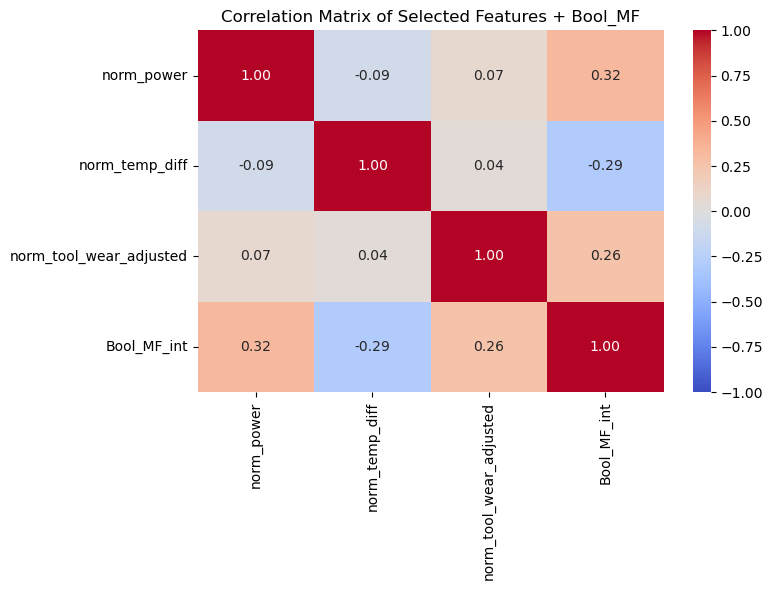

Original DataFrame memory footprint: 0.26 MB

X_train shape: (15443, 3)
X_test shape: (3861, 3)
y_train distribution:
 Bool_MF
1    0.500032
0    0.499968
Name: proportion, dtype: float64
y_test distribution:
 Bool_MF
0    0.50013
1    0.49987
Name: proportion, dtype: float64


In [5]:
# Define data types and columns for efficient loading
dtype_dict = {
    'norm_power': 'float32',
    'norm_temp_diff': 'float32',
    'norm_tool_wear_adjusted': 'float32',
    'Bool_MF': 'bool'
}
use_columns = ['norm_power', 'norm_temp_diff', 'norm_tool_wear_adjusted', 'Bool_MF']

# Load data
# Consider adding engine='pyarrow' or engine='fastparquet' if reading from parquet for potential speedup
data = pd.read_csv("full_normalized.csv", dtype=dtype_dict, usecols=use_columns, memory_map=True)
print("Data head:")
display(data.head()) # Use display for better rendering in Jupyter

# Prepare data for correlation matrix
data["Bool_MF_int"] = data["Bool_MF"].astype('int8')
features_of_interest = ['norm_power', 'norm_temp_diff', 'norm_tool_wear_adjusted', 'Bool_MF_int']
corr_matrix = data[features_of_interest].corr()
print("\n=== Correlation Matrix ===")
display(corr_matrix) # Use display

# Plot correlation matrix
# Standardized width = 8 inches
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f") # Added fmt for annotation
plt.title("Correlation Matrix of Selected Features + Bool_MF")
plt.tight_layout()
plt.show()

# Prepare features (X) and target (y)
X = data[['norm_power', 'norm_temp_diff', 'norm_tool_wear_adjusted']]
y = data['Bool_MF'].astype('int8') # Convert target to int (0/1)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Clean up memory
original_data_memory = data.memory_usage(deep=True).sum()
del data
gc.collect()
print(f"Original DataFrame memory footprint: {original_data_memory / 1024**2:.2f} MB")

# Convert data to XGBoost DMatrix format for GPU efficiency AFTER splitting
# Enable feature names for better plot interpretation later
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist(), enable_categorical=False)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X.columns.tolist(), enable_categorical=False)

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

## PART 2: Decision Tree Classifier

Train a baseline Decision Tree, visualize its structure (limited depth), tune its hyperparameters using `GridSearchCV`, and evaluate both baseline and tuned models.
Integrated different parameters into the grild from Yara's work, with restrictions for overfitting


--- Baseline Decision Tree ---
Baseline Decision Tree - Training Accuracy: 1.0000
Baseline Decision Tree - Test Accuracy:      0.9306
Decision Tree Baseline CV Mean Score: 0.9303891923036278

Decision Tree Confusion Matrix (Test):
 [[1780  151]
 [ 117 1813]]

Decision Tree Classification Report (Test):
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1931
           1       0.92      0.94      0.93      1930

    accuracy                           0.93      3861
   macro avg       0.93      0.93      0.93      3861
weighted avg       0.93      0.93      0.93      3861



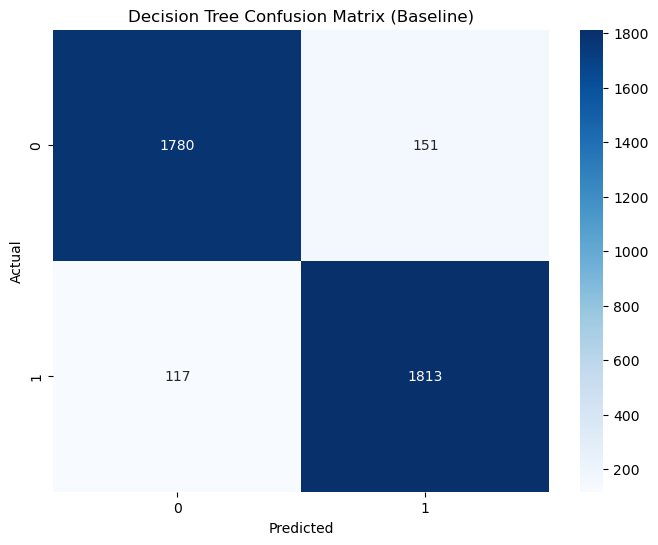

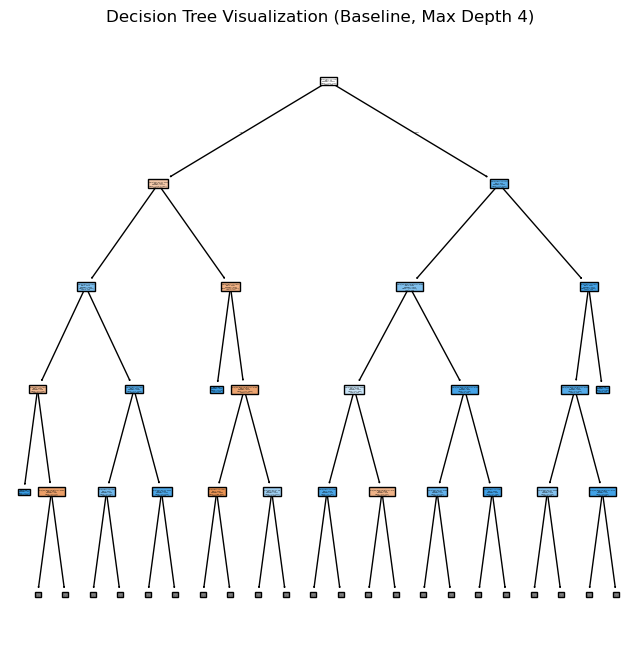


--- Decision Tree Hyperparameter Tuning (GridSearch) ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

--- Tuned Decision Tree Evaluation ---
Best Decision Tree parameters (GridSearch): {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}

Best Decision Tree - Training Accuracy: 0.9259
Best Decision Tree - Test Accuracy:   0.8961
Best Decision Tree CV Score (from GridSearch): 0.9011197387688556

Best Decision Tree Classification Report (Test):
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1931
           1       0.90      0.89      0.90      1930

    accuracy                           0.90      3861
   macro avg       0.90      0.90      0.90      3861
weighted avg       0.90      0.90      0.90      3861



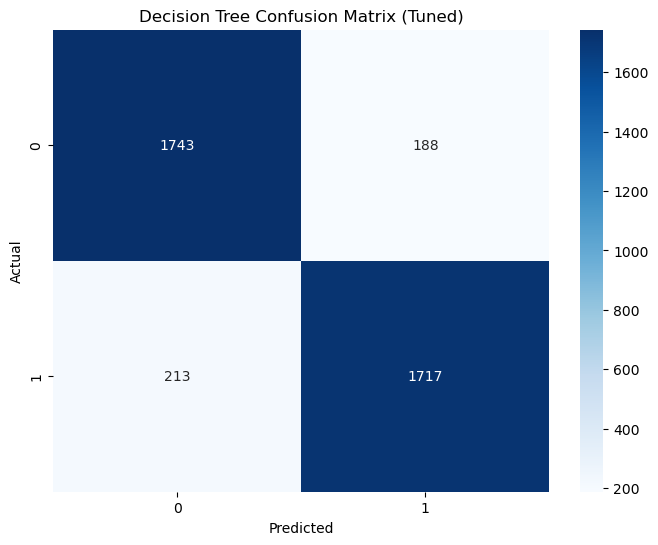

In [6]:
# --- Baseline Decision Tree ---
print("\n--- Baseline Decision Tree ---")
dt_baseline = DecisionTreeClassifier(criterion="gini", max_depth=None, random_state=42)
dt_baseline.fit(X_train, y_train)
dt_train_preds = dt_baseline.predict(X_train)
dt_test_preds = dt_baseline.predict(X_test)
dt_train_acc = accuracy_score(y_train, dt_train_preds)
dt_test_acc = accuracy_score(y_test, dt_test_preds)
print(f"Baseline Decision Tree - Training Accuracy: {dt_train_acc:.4f}")
print(f"Baseline Decision Tree - Test Accuracy:      {dt_test_acc:.4f}")
# Note: CV uses the estimator's clone, might not reflect exact baseline fit if parameters differ subtly
dt_cv_scores = cross_val_score(dt_baseline, X_train, y_train, cv=5, scoring='accuracy')
print("Decision Tree Baseline CV Mean Score:", dt_cv_scores.mean())

# --- Baseline Evaluation ---
dt_cm = confusion_matrix(y_test, dt_test_preds)
print("\nDecision Tree Confusion Matrix (Test):\n", dt_cm)
print("\nDecision Tree Classification Report (Test):\n", classification_report(y_test, dt_test_preds))

plt.figure(figsize=(8, 6)) # Standard width
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Baseline)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Plotting Baseline (Optional, Limited Depth) ---
plot_depth_dt_base = 4
plt.figure(figsize=(8, max(6, 2 * plot_depth_dt_base))) # Standard width, adjust height
plot_tree(dt_baseline, feature_names=X.columns.tolist(), class_names=["False", "True"], filled=True, max_depth=plot_depth_dt_base)
plt.title(f"Decision Tree Visualization (Baseline, Max Depth {plot_depth_dt_base})")
plt.show()

# --- Decision Tree Hyperparameter Tuning (GridSearch) ---
print("\n--- Decision Tree Hyperparameter Tuning (GridSearch) ---")

# Integrated original dt_param_grid with Update_Model_2's version, with tweaks for overfitting prevention
dt_param_grid = {
    'max_depth': [6, 8, 10], # From Update_Model_2, but range reduced slightly
    'min_samples_split': [5, 10, 15],  # From Update_Model_2 with increased minimums to reduce overfitting
    'min_samples_leaf': [2, 4, 5, 7],   # Included values from both models, min 2 to reduce overfitting
    'criterion': ['gini', 'entropy'], # From Update_Model_2
    'ccp_alpha': [0.0, 0.001, 0.01] # Added Cost-Complexity Pruning parameter
}
dt_grid = GridSearchCV(DecisionTreeClassifier(criterion='gini', random_state=42),
                       dt_param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
dt_grid.fit(X_train, y_train)

# --- Tuned Decision Tree Evaluation ---
print("\n--- Tuned Decision Tree Evaluation ---")
print("Best Decision Tree parameters (GridSearch):", dt_grid.best_params_)
best_dt = dt_grid.best_estimator_
best_dt_train_preds = best_dt.predict(X_train) # Calculate train accuracy for best model
best_dt_test_preds = best_dt.predict(X_test)
best_dt_train_acc = accuracy_score(y_train, best_dt_train_preds)
best_dt_test_acc = accuracy_score(y_test, best_dt_test_preds)
print(f"\nBest Decision Tree - Training Accuracy: {best_dt_train_acc:.4f}")
print(f"Best Decision Tree - Test Accuracy:   {best_dt_test_acc:.4f}")
print("Best Decision Tree CV Score (from GridSearch):", dt_grid.best_score_)
print("\nBest Decision Tree Classification Report (Test):\n", classification_report(y_test, best_dt_test_preds))

# Confusion matrix for best DT
dt_cm_best = confusion_matrix(y_test, best_dt_test_preds)
plt.figure(figsize=(8, 6)) # Standard width
sns.heatmap(dt_cm_best, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## PART 3: Random Forest Classifier

Train a baseline Random Forest, visualize an example tree (limited depth), tune its hyperparameters using `RandomizedSearchCV` instead of `GridSearchCV` (To match the better results from Yara's model), and evaluate both baseline and tuned models.


--- Baseline Random Forest ---
Baseline Random Forest - Training Accuracy: 1.0000
Baseline Random Forest - Test Accuracy:      0.9329
Random Forest Baseline CV Mean Score: 0.9345980094837607

Random Forest Confusion Matrix (Test):
 [[1803  128]
 [ 131 1799]]

Random Forest Classification Report (Test):
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1931
           1       0.93      0.93      0.93      1930

    accuracy                           0.93      3861
   macro avg       0.93      0.93      0.93      3861
weighted avg       0.93      0.93      0.93      3861



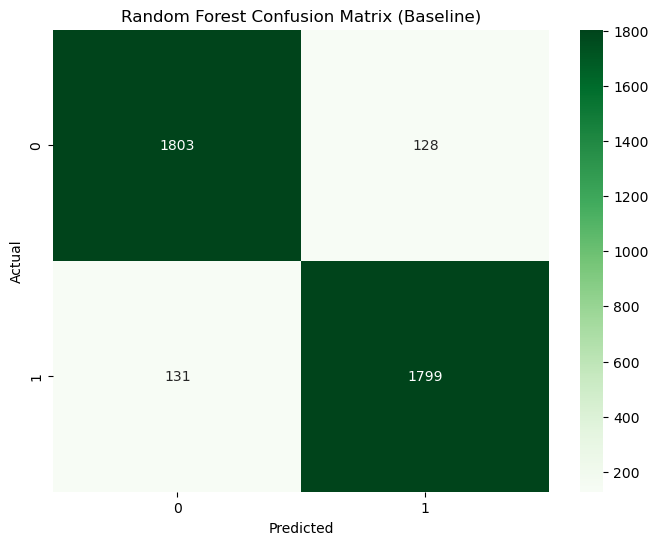

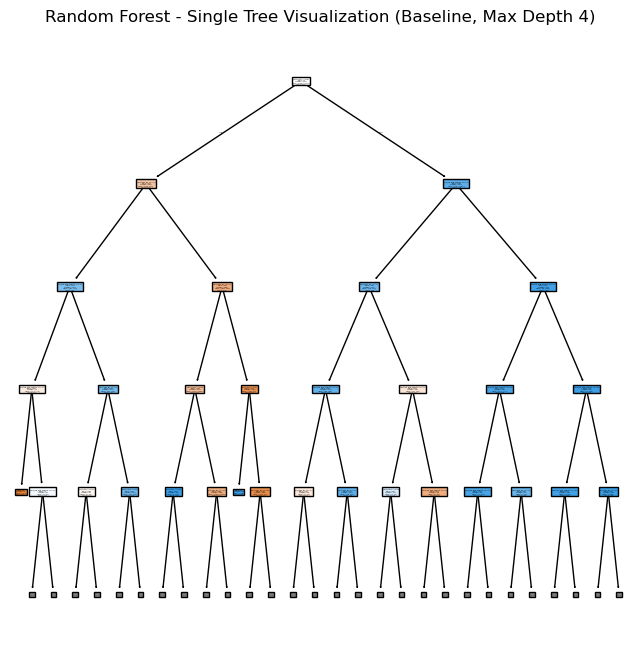


--- Random Forest Hyperparameter Tuning (RandomizedSearchCV) ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [7]:
# --- Baseline Random Forest ---
print("\n--- Baseline Random Forest ---")
rf_baseline = RandomForestClassifier(random_state=42, n_jobs=-1) # Use n_jobs here too
rf_baseline.fit(X_train, y_train)
rf_train_preds = rf_baseline.predict(X_train)
rf_test_preds = rf_baseline.predict(X_test)
rf_train_acc = accuracy_score(y_train, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
print(f"Baseline Random Forest - Training Accuracy: {rf_train_acc:.4f}")
print(f"Baseline Random Forest - Test Accuracy:      {rf_test_acc:.4f}")
rf_cv_scores = cross_val_score(rf_baseline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("Random Forest Baseline CV Mean Score:", rf_cv_scores.mean())

# --- Baseline RF Evaluation ---
rf_cm = confusion_matrix(y_test, rf_test_preds)
print("\nRandom Forest Confusion Matrix (Test):\n", rf_cm)
print("\nRandom Forest Classification Report (Test):\n", classification_report(y_test, rf_test_preds))

plt.figure(figsize=(8, 6)) # Standard width
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix (Baseline)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Plotting Baseline Tree (Optional, Limited Depth) ---
plot_depth_rf_base = 4
plt.figure(figsize=(8, max(6, 2 * plot_depth_rf_base))) # Standard width, adjust height
plot_tree(rf_baseline.estimators_[0], feature_names=X.columns.tolist(), class_names=["False", "True"], filled=True, max_depth=plot_depth_rf_base)
plt.title(f"Random Forest - Single Tree Visualization (Baseline, Max Depth {plot_depth_rf_base})")
plt.show()

# --- Random Forest Hyperparameter Tuning (RandomizedSearchCV from Update_Model_2) ---
# Updated to include modules from Yara's explorations
print("\n--- Random Forest Hyperparameter Tuning (RandomizedSearchCV) ---")
from scipy.stats import randint # Make sure randint is imported

rf_param_dist = {
    'n_estimators': randint(50, 200),      # From Update_Model_2 [cite: 120]
    'max_depth': randint(3, 20),          # From Update_Model_2 [cite: 120]
    'min_samples_split': randint(2, 10),  # From Update_Model_2 [cite: 120]
    'min_samples_leaf': randint(1, 4)       # From Update_Model_2 [cite: 120]
}

rf_estimator = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_random_search = RandomizedSearchCV(
    rf_estimator,
    param_distributions=rf_param_dist,
    n_iter=20, # As used in Update_Model_2[cite: 120], or adjust
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Can use -1 here for RF
    random_state=42,
    verbose=1
)
rf_random_search.fit(X_train, y_train)

# --- Tuned Random Forest Evaluation (Using RandomizedSearch results) ---
print("\n--- Tuned Random Forest Evaluation ---")
print("Best Random Forest parameters (RandomizedSearch):", rf_random_search.best_params_)
best_rf = rf_random_search.best_estimator_ # Now use the best estimator from random search
# ... (recalculate train/test accuracy and print reports for this best_rf) ...
best_rf_train_preds = best_rf.predict(X_train)
best_rf_test_preds = best_rf.predict(X_test)
best_rf_train_acc = accuracy_score(y_train, best_rf_train_preds)
best_rf_test_acc = accuracy_score(y_test, best_rf_test_preds)
print(f"\nBest Random Forest - Training Accuracy: {best_rf_train_acc:.4f}")
print(f"Best Random Forest - Test Accuracy:   {best_rf_test_acc:.4f}")
print("Best Random Forest CV Score (from RandomizedSearch):", rf_random_search.best_score_)
print("\nBest Random Forest Classification Report (Test):\n", classification_report(y_test, best_rf_test_preds))
# ... (plot confusion matrix for this best_rf) ...

# Confusion matrix for best RF
rf_cm_best = confusion_matrix(y_test, best_rf_test_preds)
plt.figure(figsize=(8, 6)) # Standard width
sns.heatmap(rf_cm_best, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("Section done")

## PART 4: XGBoost Classifier (GPU Accelerated)

Leverage GPU capabilities using XGBoost's DMatrix format. Train a baseline model with early stopping, perform hyperparameter tuning with `RandomizedSearchCV`, refit the best model using DMatrix and early stopping, and evaluate performance.

In [ ]:
# --- Baseline XGBoost Fit using DMatrix and Early Stopping ---
print("\n--- Fitting Baseline XGBoost with DMatrix & Early Stopping ---")
params_base = {
    'objective': 'binary:logistic', # Specify objective
    'eval_metric': 'logloss',        # Specify evaluation metric for early stopping
    'tree_method': 'hist',
    'device': 'cuda'
}
baseline_xgb_model = None # Initialize
xgb_train_acc_base = np.nan
xgb_test_acc_base = np.nan

# Train using xgb.train with DMatrix
try:
    baseline_xgb_model = xgb.train(
        params_base,
        dtrain,
        num_boost_round=200, # Set a max number of rounds
        evals=[(dtest, 'eval')], # Provide DMatrix evaluation set
        early_stopping_rounds=10, # Enable early stopping
        verbose_eval=False # Suppress round-by-round output
    )
    print(f"Baseline XGBoost stopped after {baseline_xgb_model.best_iteration + 1} rounds.")

    # Make predictions (xgb.train returns a Booster object, predict needs DMatrix)
    baseline_xgb_train_preds_proba = baseline_xgb_model.predict(dtrain, iteration_range=(0, baseline_xgb_model.best_iteration + 1))
    baseline_xgb_test_preds_proba = baseline_xgb_model.predict(dtest, iteration_range=(0, baseline_xgb_model.best_iteration + 1))
    # Convert probabilities to binary predictions (0 or 1)
    baseline_xgb_train_preds = (baseline_xgb_train_preds_proba > 0.5).astype(int)
    baseline_xgb_test_preds = (baseline_xgb_test_preds_proba > 0.5).astype(int)

    xgb_train_acc_base = accuracy_score(y_train, baseline_xgb_train_preds)
    xgb_test_acc_base = accuracy_score(y_test, baseline_xgb_test_preds)
    print(f"Baseline XGBoost (DMatrix) - Training Accuracy: {xgb_train_acc_base:.4f}")
    print(f"Baseline XGBoost (DMatrix) - Test Accuracy:      {xgb_test_acc_base:.4f}")

    # Baseline evaluation reports
    print("\nBaseline XGBoost Classification Report (Test):\n", classification_report(y_test, baseline_xgb_test_preds))
    xgb_cm_base = confusion_matrix(y_test, baseline_xgb_test_preds)
    plt.figure(figsize=(8, 6)) # Standard width
    sns.heatmap(xgb_cm_base, annot=True, fmt='d', cmap='Purples')
    plt.title("XGBoost Confusion Matrix (Baseline)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

except Exception as e:
    print(f"Error during baseline XGBoost DMatrix training: {e}")

# --- Enhanced Hyperparameter Tuning for XGBoost (Single Run) ---
print("\n--- XGBoost Randomized Hyperparameter Tuning ---")
N_ITER_SEARCH = 30 # Increased from 10, adjust as needed
xgb_param_dist = {
    'n_estimators': [100, 150, 200, 250, 300], # Max rounds if no early stopping in CV
    'max_depth': [4, 6, 8, 10],              # Max depth of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.15], # Step size shrinkage
    'subsample': [0.7, 0.8, 0.9, 1.0],         # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Fraction of features used per tree
    'gamma': [0, 0.1, 0.5, 1],                 # Min loss reduction for split (regularization)
    'reg_alpha': [0, 0.01, 0.1, 1],           # L1 regularization
    'reg_lambda': [1, 1.5, 2, 3]              # L2 regularization
}

xgb_estimator = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    device='cuda',
    random_state=42
    # Removed 'use_label_encoder=False'
)

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) # Reduced repeats slightly for speed

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_estimator,
    param_distributions=xgb_param_dist,
    n_iter=N_ITER_SEARCH,
    scoring='accuracy',
    cv=rkf,
    n_jobs=1, # Often necessary when using GPU within CV to avoid resource conflicts
    random_state=42,
    verbose=1 # Show progress
)

# Fit RandomizedSearchCV using CPU data (standard practice for scikit-learn)
xgb_random_search.fit(X_train, y_train) # Pass X_train (Pandas/NumPy)

# --- Tuned XGBoost Evaluation ---
print("\n--- Tuned XGBoost Evaluation ---")
print("Best XGBoost parameters (RandomizedSearchCV):", xgb_random_search.best_params_)
print("Best XGBoost CV Score (RandomizedSearchCV):", xgb_random_search.best_score_)

# --- Refit Best XGBoost Estimator using DMatrix & Early Stopping ---
print("\n--- Refitting Best XGBoost Estimator with DMatrix & Early Stopping ---")
best_params = xgb_random_search.best_params_.copy()
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_params['tree_method'] = 'hist'
best_params['device'] = 'cuda'
num_boost_round = best_params.pop('n_estimators', 200)

best_xgb_model = None # Initialize
best_xgb_train_acc = np.nan
best_xgb_test_acc = np.nan

try:
    best_xgb_model = xgb.train(
        best_params, # Pass parameters dictionary
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, 'eval')],
        early_stopping_rounds=10, # Use early stopping during refit
        verbose_eval=False
    )
    print(f"Best XGBoost model refitted, stopped after {best_xgb_model.best_iteration + 1} rounds.")

    # Make predictions using the best iteration
    best_xgb_train_preds_proba = best_xgb_model.predict(dtrain, iteration_range=(0, best_xgb_model.best_iteration + 1))
    best_xgb_test_preds_proba = best_xgb_model.predict(dtest, iteration_range=(0, best_xgb_model.best_iteration + 1))
    best_xgb_train_preds = (best_xgb_train_preds_proba > 0.5).astype(int)
    best_xgb_test_preds = (best_xgb_test_preds_proba > 0.5).astype(int)

    # Calculate accuracies
    best_xgb_train_acc = accuracy_score(y_train, best_xgb_train_preds)
    best_xgb_test_acc = accuracy_score(y_test, best_xgb_test_preds)

    print(f"\nBest XGBoost (DMatrix, Refitted) - Training Accuracy: {best_xgb_train_acc:.4f}")
    print(f"Best XGBoost (DMatrix, Refitted) - Test Accuracy:   {best_xgb_test_acc:.4f}")
    print("\nBest XGBoost Classification Report (Test):\n", classification_report(y_test, best_xgb_test_preds))

    # Confusion Matrix
    xgb_cm_best = confusion_matrix(y_test, best_xgb_test_preds)
    plt.figure(figsize=(8, 6)) # Standard width
    sns.heatmap(xgb_cm_best, annot=True, fmt='d', cmap='Purples')
    plt.title("XGBoost Confusion Matrix (Tuned)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # --- Feature Importance ---
    plt.figure(figsize=(8, 4)) # Standard width, adjust height
    xgb.plot_importance(best_xgb_model, ax=plt.gca()) # Pass axis
    plt.title("Best XGBoost Feature Importances (DMatrix)")
    plt.show()

except Exception as e:
    print(f"Error during best XGBoost DMatrix refitting: {e}")

print("Section done")

## PART 5: Overfitting Analysis & Comprehensive Report

Analyze the difference between training and test accuracy for each model to assess overfitting. Generate a consolidated performance summary table and comparison plots.

In [ ]:
print("\n--- Overfitting Check (Train Acc vs Test Acc) ---")
print(f"Decision Tree (Best):    Train={best_dt_train_acc:.4f} Test={best_dt_test_acc:.4f} Diff={(best_dt_train_acc - best_dt_test_acc):.4f}")
print(f"Random Forest (Best):    Train={best_rf_train_acc:.4f} Test={best_rf_test_acc:.4f} Diff={(best_rf_train_acc - best_rf_test_acc):.4f}")
if 'best_xgb_model' in locals() and best_xgb_model: # Check if XGBoost training succeeded
    print(f"XGBoost (Best, DMatrix): Train={best_xgb_train_acc:.4f} Test={best_xgb_test_acc:.4f} Diff={(best_xgb_train_acc - best_xgb_test_acc):.4f}")
else:
    print("XGBoost (Best, DMatrix): Training failed, cannot report accuracy.")

# Add baseline model comparisons if desired
print(f"\nDecision Tree (Baseline): Train={dt_train_acc:.4f} Test={dt_test_acc:.4f} Diff={(dt_train_acc - dt_test_acc):.4f}")
print(f"Random Forest (Baseline): Train={rf_train_acc:.4f} Test={rf_test_acc:.4f} Diff={(rf_train_acc - rf_test_acc):.4f}")
if 'baseline_xgb_model' in locals() and baseline_xgb_model:
     print(f"XGBoost (Baseline, DMatrix): Train={xgb_train_acc_base:.4f} Test={xgb_test_acc_base:.4f} Diff={(xgb_train_acc_base - xgb_test_acc_base):.4f}")


# --- Comprehensive Report DataFrame ---
summary_data = {
    'Model': ['Decision Tree (Best)', 'Random Forest (Best)', 'XGBoost (Best, DMatrix)'],
    'Train Accuracy': [best_dt_train_acc, best_rf_train_acc, best_xgb_train_acc if 'best_xgb_model' in locals() and best_xgb_model else np.nan],
    'Test Accuracy': [best_dt_test_acc, best_rf_test_acc, best_xgb_test_acc if 'best_xgb_model' in locals() and best_xgb_model else np.nan],
    'CV Score (Mean)': [
        dt_grid.best_score_ if 'dt_grid' in locals() else np.nan, # Check dt_grid exists
        rf_random_search.best_score_ if 'rf_random_search' in locals() else np.nan, # Use rf_random_search score conditionally
        xgb_random_search.best_score_ if 'xgb_random_search' in locals() else np.nan # Check xgb_random_search exists
    ]
}
# Optionally add baseline results
summary_data['Model'].extend(['Decision Tree (Baseline)', 'Random Forest (Baseline)', 'XGBoost (Baseline, DMatrix)'])
summary_data['Train Accuracy'].extend([dt_train_acc, rf_train_acc, xgb_train_acc_base if 'baseline_xgb_model' in locals() and baseline_xgb_model else np.nan])
summary_data['Test Accuracy'].extend([dt_test_acc, rf_test_acc, xgb_test_acc_base if 'baseline_xgb_model' in locals() and baseline_xgb_model else np.nan])
# Add placeholder for baseline CV Scores - ensure variables exist
dt_cv_mean = dt_cv_scores.mean() if 'dt_cv_scores' in locals() else np.nan
rf_cv_mean = rf_cv_scores.mean() if 'rf_cv_scores' in locals() else np.nan
summary_data['CV Score (Mean)'].extend([dt_cv_mean, rf_cv_mean, np.nan]) # Baseline CV score for XGBoost not directly comparable


summary_df = pd.DataFrame(summary_data)
# Sort or filter as needed
summary_df = summary_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
print("\n=== Comprehensive Model Performance Summary ===")
# Use display for better table rendering in Jupyter
display(summary_df)

# --- Comparison Plots ---
# Test Accuracy Plot (First Plot)
num_models = len(summary_df['Model'].unique())
plot_height = max(4, num_models * 0.6)
plt.figure(figsize=(8, plot_height)) # Standard width
sns.barplot(
    x='Test Accuracy',
    y='Model',
    data=summary_df,
    palette='viridis',
    orient='h',
    hue='Model', # Use hue for color mapping
    legend=False # Disable legend as requested previously
)
plt.title("Test Accuracy Comparison Across Models")
plt.xlabel("Test Accuracy")
plt.ylabel("Model")
min_acc = summary_df['Test Accuracy'].min(skipna=True) - 0.01 # Added skipna
plt.xlim([max(0.85, min_acc), 1.00])
plt.tight_layout()
plt.show()

# --- Train vs Test Plot (Second Plot - MODIFIED) ---

# 1. Calculate the difference (moved before the print statement)
if 'Train Accuracy' in summary_df.columns and 'Test Accuracy' in summary_df.columns:
    summary_df['Diff'] = summary_df['Train Accuracy'] - summary_df['Test Accuracy']
else:
    summary_df['Diff'] = np.nan # Handle case where columns might be missing

# Display dataframe with the new 'Diff' column (optional display here)
print("\n=== Comprehensive Model Performance Summary (with Diff) ===")
display(summary_df)

# --- Plot Train vs Test Accuracy with Colors in Title ---

num_models = len(summary_df['Model'].unique())
plot_height = max(4, num_models * 0.7)
plt.figure(figsize=(8, plot_height)) # Standard width

# Prepare data for melt
plot_df = summary_df.melt(id_vars='Model', var_name='Accuracy Type', value_name='Accuracy Score',
                          value_vars=['Train Accuracy', 'Test Accuracy'])

# Get the first two colors from the 'muted' palette
muted_colors = sns.color_palette('muted')[:2]
# Manually identify approximate color names (adjust if needed)
train_color_name = "Blue" # Typically the first muted color
test_color_name = "Orange" # Typically the second muted color

# Create the plot and get the axes object
ax = sns.barplot(x='Accuracy Score', y='Model', hue='Accuracy Type', data=plot_df, palette=muted_colors, orient='h') # Use the specific colors

# --- MODIFIED TITLE ---
plt.title(f'{train_color_name}=Train vs {test_color_name}=Test Accuracy (with Overfitting Diff)')
# --- END MODIFIED TITLE ---

plt.xlabel('Accuracy')
plt.ylabel('Model')

# Define plot limits BEFORE placing text
plot_xmin = 0.85 # Set a reasonable minimum default
if plot_df['Accuracy Score'].notna().any():
    plot_xmin = max(0.85, plot_df['Accuracy Score'].min(skipna=True) - 0.01)
plot_xmax = 1.01
plt.xlim([plot_xmin, plot_xmax]) # Adjust xlim

# --- REMOVE LEGEND ---
ax.get_legend().remove()
# --- END REMOVE LEGEND ---

# Add text annotations for the difference near the Y-axis labels (Keep this part)
for index, model_name in enumerate(summary_df['Model']):
    if model_name in summary_df['Model'].values:
        model_data = summary_df[summary_df['Model'] == model_name].iloc[0]
        diff = model_data.get('Diff', np.nan)

        if pd.notna(diff):
            x_pos = plot_xmin + 0.002
            y_pos = index

            ax.text(x=x_pos,
                    y=y_pos,
                    s=f"Diff={diff:.4f}",
                    color='black',
                    va='center',
                    ha='left',
                    fontsize=7,
                    bbox=dict(
                        boxstyle='round,pad=0.2',
                        facecolor='yellow',
                        alpha=0.6
                    )
                   )

# Adjust layout - need left margin for text, but less need for right margin now
plt.tight_layout()
# Adjust left margin for text, right margin can be smaller
plt.subplots_adjust(left=0.40, right=0.95) # Reduced right margin

plt.show()

print("Section done")

## PART 6: Model Ensembling via Stacking

Combine the predictive power of the best-tuned Decision Tree, Random Forest, and XGBoost models using a `StackingClassifier` with a Logistic Regression meta-learner. Evaluate the ensemble's performance.

In [ ]:
print("\n--- Stacking Ensemble ---")
# Ensure the best models exist before stacking
if best_xgb_model: # Check if best XGBoost model was trained successfully
    # Need the scikit-learn wrapper version of the best XGBoost model for StackingClassifier
    best_xgb_sklearn = XGBClassifier(**xgb_random_search.best_params_,
                                     objective='binary:logistic', eval_metric='logloss',
                                     tree_method='hist', device='cuda', random_state=42)
                                     # Removed 'use_label_encoder=False'
    # Fit the sklearn wrapper on the training data
    print("Fitting XGBoost wrapper for Stacking...")
    best_xgb_sklearn.fit(X_train, y_train) # Fit the wrapper

    estimators = [
        ('dt', best_dt), # Best Decision Tree from GridSearchCV
        ('rf', best_rf), # Best Random Forest from GridSearchCV
        ('xgb', best_xgb_sklearn) # Sklearn wrapper of best XGBoost
    ]
    # Note: Increase C for less regularization if needed
    final_estimator = LogisticRegression(max_iter=1000, C=1.0, random_state=42)

    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5, # Cross-validation strategy for meta-features
        n_jobs=-1, # Use parallel jobs for CV
        passthrough=False, # Whether to pass original features to final estimator
        verbose=1
    )

    print("\n--- Fitting Stacking Ensemble ---")
    stacking_clf.fit(X_train, y_train) # Fit on training data
    print("\n--- Evaluating Stacking Ensemble ---")
    stack_train_preds = stacking_clf.predict(X_train)
    stack_test_preds = stacking_clf.predict(X_test)
    stack_train_acc = accuracy_score(y_train, stack_train_preds)
    stack_test_acc = accuracy_score(y_test, stack_test_preds)
    print(f"\nStacking Ensemble - Training Accuracy: {stack_train_acc:.4f}")
    print(f"Stacking Ensemble - Test Accuracy:      {stack_test_acc:.4f}")
    print(f"Stacking Ensemble - Overfitting Diff: {(stack_train_acc - stack_test_acc):.4f}")

    stack_cm = confusion_matrix(y_test, stack_test_preds)
    print("\nStacking Ensemble Confusion Matrix (Test):\n", stack_cm)
    print("\nStacking Ensemble Classification Report (Test):\n", classification_report(y_test, stack_test_preds))

    plt.figure(figsize=(8, 6)) # Standard width
    sns.heatmap(stack_cm, annot=True, fmt='d', cmap='coolwarm')
    plt.title("Stacking Ensemble Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Append Stacking results to summary_df
    stack_row = pd.DataFrame([{
        'Model': 'Stacking Ensemble',
        'Train Accuracy': stack_train_acc,
        'Test Accuracy': stack_test_acc,
        'CV Score (Mean)': np.nan # CV score not directly comparable/available
    }])
    summary_df = pd.concat([summary_df, stack_row], ignore_index=True)

else:
    print("Skipping Stacking Ensemble because best XGBoost model training failed.")
    stacking_clf = None # Ensure variable exists but is None

print("Section done")

## PART 7: Save Final Results

Consolidate and save the detailed hyperparameter tuning results from all models into a single CSV file. Save the final summary table comparing all evaluated models to another CSV file.

In [ ]:
# --- Consolidate and Save ALL Hyperparameter Tuning Results ---
print("\n--- Consolidating Hyperparameter Tuning Results ---")

# Extract and prepare Decision Tree results
try:
    dt_results_df = pd.DataFrame(dt_grid.cv_results_)
    dt_results_df['model_type'] = 'Decision Tree'
    dt_cols_to_keep = ['model_type', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    dt_results_df = dt_results_df[[col for col in dt_cols_to_keep if col in dt_results_df.columns]]
    print("Decision Tree tuning results prepared.")
except NameError:
    print("Decision Tree grid search object ('dt_grid') not found or 'cv_results_' missing.")
    dt_results_df = pd.DataFrame()

# Extract and prepare Random Forest results
try:
    rf_results_df = pd.DataFrame(rf_grid.cv_results_)
    rf_results_df['model_type'] = 'Random Forest'
    rf_cols_to_keep = ['model_type', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    rf_results_df = rf_results_df[[col for col in rf_cols_to_keep if col in rf_results_df.columns]]
    print("Random Forest tuning results prepared.")
except NameError:
    print("Random Forest grid search object ('rf_grid') not found or 'cv_results_' missing.")
    rf_results_df = pd.DataFrame()

# Extract and prepare XGBoost results
try:
    xgb_results_df = pd.DataFrame(xgb_random_search.cv_results_)
    xgb_results_df['model_type'] = 'XGBoost'
    xgb_cols_to_keep = ['model_type', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    xgb_results_df = xgb_results_df[[col for col in xgb_cols_to_keep if col in xgb_results_df.columns]]
    print("XGBoost tuning results prepared.")
except NameError:
    print("XGBoost random search object ('xgb_random_search') not found or 'cv_results_' missing.")
    xgb_results_df = pd.DataFrame()

# Combine results
all_tuning_results_df = pd.concat([dt_results_df, rf_results_df, xgb_results_df], ignore_index=True)

# Sort by rank within each model type (optional)
if not all_tuning_results_df.empty and 'rank_test_score' in all_tuning_results_df.columns:
    all_tuning_results_df = all_tuning_results_df.sort_values(by=['model_type', 'rank_test_score'])

# Save combined results to a single CSV
if not all_tuning_results_df.empty:
    output_filename_tuning = "all_models_hyperparameter_tuning_results.csv"
    all_tuning_results_df.to_csv(output_filename_tuning, index=False)
    print(f"Combined hyperparameter tuning results saved to '{output_filename_tuning}'.")
else:
    print("No tuning results were generated or extracted, skipping combined save.")


# --- Create and Save Final Model Summary ---
print("\n--- Preparing Final Model Summary ---")
model_results_list = [
     {
        "Model": "Decision Tree (Baseline)",
        "Description": "Basic decision tree with default parameters.",
        "Hyperparameters": "default",
        "Train Accuracy": dt_train_acc,
        "Test Accuracy": dt_test_acc,
        "CV Score": dt_cv_scores.mean()
    },
    {
        "Model": "Decision Tree (Best)",
        "Description": "Tuned decision tree using GridSearchCV.",
        "Hyperparameters": str(dt_grid.best_params_),
        "Train Accuracy": best_dt_train_acc,
        "Test Accuracy": best_dt_test_acc,
        "CV Score": dt_grid.best_score_
    },
    {
        "Model": "Random Forest (Baseline)",
        "Description": "Basic random forest with default parameters.",
        "Hyperparameters": "default",
        "Train Accuracy": rf_train_acc,
        "Test Accuracy": rf_test_acc,
        "CV Score": rf_cv_scores.mean()
    },
    {
        "Model": "Random Forest (Best)",
        # Check if RandomizedSearchCV ran and assign results accordingly
        "Description": "Tuned random forest using RandomizedSearchCV." if 'rf_random_search' in locals() else "Tuned random forest (GridSearchCV - check variable name)",
        "Hyperparameters": str(rf_random_search.best_params_) if 'rf_random_search' in locals() else "Search Not Run or Variable Mismatch",
        "Train Accuracy": best_rf_train_acc, # Ensure this variable is calculated after the chosen search
        "Test Accuracy": best_rf_test_acc,   # Ensure this variable is calculated after the chosen search
        "CV Score": rf_random_search.best_score_ if 'rf_random_search' in locals() else np.nan # Use score from RandomizedSearch
    },
    {
        "Model": "XGBoost (Baseline, DMatrix)",
        "Description": "Baseline XGBoost classifier on GPU with DMatrix & early stopping.",
        "Hyperparameters": "default",
        "Train Accuracy": xgb_train_acc_base if baseline_xgb_model else np.nan,
        "Test Accuracy": xgb_test_acc_base if baseline_xgb_model else np.nan,
        "CV Score": np.nan # CV not run in the same way for xgb.train baseline
    },
    {
        "Model": "XGBoost (Best, DMatrix)",
        "Description": "Tuned XGBoost classifier using RandomizedSearchCV, refitted with DMatrix.",
        "Hyperparameters": str(xgb_random_search.best_params_) if 'xgb_random_search' in locals() else "Search Failed",
        "Train Accuracy": best_xgb_train_acc if best_xgb_model else np.nan,
        "Test Accuracy": best_xgb_test_acc if best_xgb_model else np.nan, # Directly use the final test accuracy
        "CV Score": xgb_random_search.best_score_ if 'xgb_random_search' in locals() else np.nan
    }
]

# Add Stacking result if it ran and the variable exists
if 'stacking_clf' in locals() and stacking_clf is not None:
     # --- MODIFIED SECTION ---
     # Get best params conditionally
     dt_params_str = str(dt_grid.best_params_) if 'dt_grid' in locals() else 'N/A'
     # Use rf_random_search here
     rf_params_str = str(rf_random_search.best_params_) if 'rf_random_search' in locals() else 'N/A'
     xgb_params_str = str(xgb_random_search.best_params_) if 'xgb_random_search' in locals() else 'N/A'
     final_est_str = str(stacking_clf.final_estimator_)

     model_results_list.append({
        "Model": "Stacking Ensemble",
        "Description": "Stacking ensemble using best DT, best RF, and best XGBoost wrapper with Logistic Regression meta-estimator.",
        # Updated f-string using conditional params
        "Hyperparameters": f"Components: DT={dt_params_str}, RF={rf_params_str}, XGB={xgb_params_str}; Final Estimator: {final_est_str}",
        "Train Accuracy": stack_train_acc,
        "Test Accuracy": stack_test_acc,
        "CV Score": np.nan # Not directly comparable
    })


results_final_df = pd.DataFrame(model_results_list)
output_filename_summary = "model_results_summary_optimized.csv"
results_final_df.to_csv(output_filename_summary, index=False)
print(f"Final model results summary saved to '{output_filename_summary}'.")

# Display final summary table again for confirmation
print("\n=== Final Model Results Summary Table ===")
display(results_final_df) # Use display in Jupyter

print("\n--- Workflow Complete ---")

print("Section done")

## PART X: Recall-Focused Explorations

### Purpose
This section of the notebook demonstrates two ways to emphasize recall (i.e., reducing false negatives):
1. **Threshold Tuning** on your already-trained XGBoost booster (`best_xgb_model`) by scanning different probability thresholds.
2. **Class-Weighted Retraining** using the scikit-learn XGBClassifier wrapper with `scale_pos_weight`, which assigns more importance to the minority (failure) class.

### Code Overview

1. **Threshold Tuning**  
   - We use `best_xgb_model.predict(dtest)` to obtain predicted probabilities (`test_proba`), then scan through thresholds from 0.1 to 0.9 in increments of 0.1.  
   - For each threshold, we convert the probabilities to binary predictions and compute **recall, precision, and accuracy**.  
   - We plot these metrics against the different thresholds, helping us identify which threshold yields the desired balance (potentially improving recall at the cost of precision or overall accuracy).

2. **Class-Weighted Retraining**  
   - We build a new XGBClassifier (`xgb_recall_focused`) with `scale_pos_weight` set to roughly `(#negatives / #positives)` based on your training data. This gives additional weight to the minority class, typically **increasing recall** by prioritizing correct identification of failures.  
   - We fit this recall-focused model on the CPU-based `X_train, y_train`, then evaluate performance on `X_test`.  
   - We print final recall, precision, and accuracy, and display a confusion matrix to see the new false positives and false negatives trade-off.

### Key Takeaways
- **Threshold Tuning** is done after training to alter the final decision boundary. This helps you find an ideal recall–precision trade-off for your business needs.  
- **Class Weight** modifies the training loss to reduce false negatives. However, it can substantially increase false positives.  
- Always consider the costs of each type of error (false positives vs. false negatives) and choose parameter values or thresholds accordingly.


In [ ]:
# =============================================================================
# PART X: RECALL-FOCUSED EXPLORATIONS (with specific confusion matrices)
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

# 1) THRESHOLD TUNING FOR best_xgb_model (Booster from xgb.train)
print("\n=== THRESHOLD TUNING ON 'best_xgb_model' (Booster) ===")

# predict probabilities once
test_proba = best_xgb_model.predict(
    dtest,
    iteration_range=(0, best_xgb_model.best_iteration + 1)
)

# scan thresholds 0.1 → 0.9
thresholds = np.linspace(0.1, 0.9, 9)
recall_scores = []
precision_scores = []
accuracy_scores = []

print("Threshold | Recall  | Precision | Accuracy")
for th in thresholds:
    preds = (test_proba >= th).astype(int)
    rec  = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    acc  = accuracy_score(y_test, preds)
    recall_scores.append(rec)
    precision_scores.append(prec)
    accuracy_scores.append(acc)
    print(f"{th:>8.2f} | {rec:.3f}   | {prec:.3f}     | {acc:.3f}")

# plot recall/precision/accuracy vs threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, recall_scores, marker='o', label='Recall')
plt.plot(thresholds, precision_scores, marker='s', label='Precision')
plt.plot(thresholds, accuracy_scores, marker='^', label='Accuracy')
plt.title("XGBoost Threshold Tuning (Recall / Precision / Accuracy)")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.legend(); plt.grid(True)
plt.show()

# 2) Confusion matrices at specific thresholds
print("\n=== CONFUSION MATRICES @ [0.10, 0.15, 0.20, 0.25] ===")
for th in [0.10, 0.15, 0.20, 0.25]:
    preds = (test_proba >= th).astype(int)
    cm = confusion_matrix(y_test, preds)
    print(f"\n-- Threshold = {th:.2f} --")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix @ thresh={th:.2f}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# 3) (Optional) your existing class‐weighted retraining block goes here…
#    [keep the XGBClassifier scale_pos_weight code below, unchanged]


## Threshold Testing & Confusion Matrices (0.1, 0.15, 0.2)

Below is a code snippet to add to your Jupyter notebook. It shows:
1. **How to generate binary predictions** at thresholds of 0.1, 0.15, and 0.2 using your existing `best_xgb_model` (a Booster) and `dtest` (a DMatrix).
2. **Computes recall, precision, and accuracy** at each threshold.
3. **Displays confusion matrices** in heatmaps for easier interpretation of false positives (FP) vs. false negatives (FN).


In [ ]:
# Cell: Export trained XGBoost model as JSON + threshold
import joblib

best_xgb_model.save_model("xgb_gpu_model.json")      # JSON format
joblib.dump(0.20, "xgb_threshold_0.20.joblib")      # your cutoff

print("✅ Saved model → xgb_gpu_model.json")
print("✅ Saved threshold → xgb_threshold_0.20.joblib")


In [ ]:
# # Cell: Import XGBoost JSON model + threshold for inference
# import joblib
# import xgboost as xgb

# best_xgb_model = xgb.Booster()
# best_xgb_model.load_model("xgb_gpu_model.json")     # note .json here
# threshold      = joblib.load("xgb_threshold_0.20.joblib")

# def predict_failure(X_new):
#     dmat = xgb.DMatrix(X_new)
#     proba = best_xgb_model.predict(
#         dmat,
#         iteration_range=(0, loaded_booster.best_iteration + 1)
#     )
#     return (proba >= threshold).astype(int)

# print("✅ Model and threshold loaded. Use `predict_failure(X_new)`")


In [ ]:
    # --- Feature Importance ---
plt.figure(figsize=(8, 4)) # Standard width, adjust height
xgb.plot_importance(best_xgb_model, ax=plt.gca()) # Pass axis
plt.title("Best XGBoost Feature Importances by Weight")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score # Needed for threshold loop

print("\n--- Overfitting Check (Train Acc vs Test Acc) ---")
print(f"Decision Tree (Best):     Train={best_dt_train_acc:.4f} Test={best_dt_test_acc:.4f} Diff={(best_dt_train_acc - best_dt_test_acc):.4f}")
print(f"Random Forest (Best):     Train={best_rf_train_acc:.4f} Test={best_rf_test_acc:.4f} Diff={(best_rf_train_acc - best_rf_test_acc):.4f}")
if 'best_xgb_model' in locals() and best_xgb_model:
    print(f"XGBoost (Best, Default 0.5 Threshold): Train={best_xgb_train_acc:.4f} Test={best_xgb_test_acc:.4f} Diff={(best_xgb_train_acc - best_xgb_test_acc):.4f}")
else:
    print("XGBoost (Best, Default 0.5 Threshold): Training failed, cannot report accuracy.")

print(f"\nDecision Tree (Baseline): Train={dt_train_acc:.4f} Test={dt_test_acc:.4f} Diff={(dt_train_acc - dt_test_acc):.4f}")
print(f"Random Forest (Baseline): Train={rf_train_acc:.4f} Test={rf_test_acc:.4f} Diff={(rf_train_acc - rf_test_acc):.4f}")
if 'baseline_xgb_model' in locals() and baseline_xgb_model:
     print(f"XGBoost (Baseline):       Train={xgb_train_acc_base:.4f} Test={xgb_test_acc_base:.4f} Diff={(xgb_train_acc_base - xgb_test_acc_base):.4f}")


# --- Initial Comprehensive Report DataFrame ---
# (Includes the renamed default threshold XGBoost)
summary_data = {
    'Model': ['Decision Tree (Best)', 'Random Forest (Best)', 'XGBoost (Best, Default 0.5 Threshold)'],
    'Train Accuracy': [best_dt_train_acc, best_rf_train_acc, best_xgb_train_acc if 'best_xgb_model' in locals() and best_xgb_model else np.nan],
    'Test Accuracy': [best_dt_test_acc, best_rf_test_acc, best_xgb_test_acc if 'best_xgb_model' in locals() and best_xgb_model else np.nan],
    'CV Score (Mean)': [
        dt_grid.best_score_ if 'dt_grid' in locals() else np.nan,
        rf_random_search.best_score_ if 'rf_random_search' in locals() else np.nan,
        xgb_random_search.best_score_ if 'xgb_random_search' in locals() else np.nan
    ]
}
summary_data['Model'].extend(['Decision Tree (Baseline)', 'Random Forest (Baseline)', 'XGBoost (Baseline)'])
summary_data['Train Accuracy'].extend([dt_train_acc, rf_train_acc, xgb_train_acc_base if 'baseline_xgb_model' in locals() and baseline_xgb_model else np.nan])
summary_data['Test Accuracy'].extend([dt_test_acc, rf_test_acc, xgb_test_acc_base if 'baseline_xgb_model' in locals() and baseline_xgb_model else np.nan])
dt_cv_mean = dt_cv_scores.mean() if 'dt_cv_scores' in locals() else np.nan
rf_cv_mean = rf_cv_scores.mean() if 'rf_cv_scores' in locals() else np.nan
summary_data['CV Score (Mean)'].extend([dt_cv_mean, rf_cv_mean, np.nan])

summary_df = pd.DataFrame(summary_data)

# --- NEW: Calculate XGBoost Accuracies at Different Thresholds ---
records = []
# Make sure proba_train, proba_test, y_train, y_test are defined from your best XGBoost run
if 'proba_train' in locals() and 'proba_test' in locals() and 'y_train' in locals() and 'y_test' in locals():
    print("\n--- Calculating XGBoost Accuracies at Custom Thresholds ---")
    for th in [0.10, 0.15, 0.20]:
        tr_preds = (proba_train >= th).astype(int)
        te_preds = (proba_test >= th).astype(int)
        train_acc_th = accuracy_score(y_train, tr_preds)
        test_acc_th = accuracy_score(y_test, te_preds)
        # MODIFIED: Create descriptive model name
        model_name = f'XGBoost (Best, Thr={th:.2f})'
        records.append({
            'Model': model_name,
            #'Threshold': th, # Keep threshold info in the name primarily
            'Train Accuracy': train_acc_th,
            'Test Accuracy': test_acc_th
        })
        print(f"{model_name}: Train={train_acc_th:.4f} Test={test_acc_th:.4f}")

    # Convert records to DataFrame
    threshold_df = pd.DataFrame(records)

    # Add missing columns needed for concatenation
    threshold_df['CV Score (Mean)'] = np.nan # CV score isn't applicable here

    # --- Combine DataFrames ---
    summary_df = pd.concat([summary_df, threshold_df], ignore_index=True)

else:
    print("\nSkipping threshold calculations: `proba_train` or `proba_test` not found.")
# --- END NEW SECTION ---


# --- Final Processing of Combined DataFrame ---

# Calculate 'Diff' column for the *entire* DataFrame
if 'Train Accuracy' in summary_df.columns and 'Test Accuracy' in summary_df.columns:
    summary_df['Diff'] = summary_df['Train Accuracy'] - summary_df['Test Accuracy']
else:
    summary_df['Diff'] = np.nan

# Sort the final DataFrame by Test Accuracy
summary_df = summary_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

# Display the combined and sorted dataframe
print("\n=== Comprehensive Model Performance Summary (Including Thresholds) ===")
display(summary_df)


# --- Comparison Plots (Should adapt automatically) ---

# Test Accuracy Plot
num_models = len(summary_df['Model'].unique())
plot_height = max(4, num_models * 0.6) # Dynamic height
plt.figure(figsize=(10, plot_height)) # Slightly wider for potentially longer labels
sns.barplot(
    x='Test Accuracy',
    y='Model',
    data=summary_df,
    palette='viridis',
    orient='h',
    hue='Model',
    legend=False
)
plt.title("Test Accuracy Comparison Across Models (incl. Thresholds)")
plt.xlabel("Test Accuracy")
plt.ylabel("Model")
min_acc = summary_df['Test Accuracy'].min(skipna=True)
plt.xlim([max(0.80, min_acc - 0.01 if pd.notna(min_acc) else 0.80), 1.005]) # Adjust lower limit if needed
plt.tight_layout()
plt.show()


# --- Train vs Test Plot ---
print("\n=== Comprehensive Model Performance Summary (with Diff) ===")
display(summary_df[['Model', 'Train Accuracy', 'Test Accuracy', 'Diff']]) # Display relevant columns

num_models = len(summary_df['Model'].unique())
plot_height = max(4, num_models * 0.7) # Dynamic height
plt.figure(figsize=(10, plot_height)) # Slightly wider

# Prepare data for melt
plot_df = summary_df.melt(id_vars='Model', var_name='Accuracy Type', value_name='Accuracy Score',
                          value_vars=['Train Accuracy', 'Test Accuracy'])

muted_colors = sns.color_palette('muted')[:2]
train_color_name = "Blue"
test_color_name = "Orange"

if not plot_df.empty:
    ax = sns.barplot(x='Accuracy Score', y='Model', hue='Accuracy Type', data=plot_df, palette=muted_colors, orient='h')

    plt.title(f'{train_color_name}=Train vs {test_color_name}=Test Accuracy (with Overfitting Diff)')
    plt.xlabel('Accuracy')
    plt.ylabel('Model')

    plot_xmin = 0.80 # Adjusted default minimum
    if plot_df['Accuracy Score'].notna().any():
        min_score = plot_df['Accuracy Score'].min(skipna=True)
        plot_xmin = max(0.80, min_score - 0.01 if pd.notna(min_score) else 0.80)
    plot_xmax = 1.01
    plt.xlim([plot_xmin, plot_xmax])

    if ax.get_legend():
        ax.get_legend().remove()

    # Add text annotations for the difference
    for index, row in summary_df.iterrows(): # Use iterrows to get index easily
        model_name = row['Model']
        diff = row.get('Diff', np.nan)

        if pd.notna(diff):
            # Use plot_xmin for consistent positioning relative to the plot edge
            x_pos = plot_xmin + 0.002
            y_pos = index # Use the DataFrame index which corresponds to the plot order after sorting

            ax.text(x=x_pos, y=y_pos, s=f"{diff:.4f}", color='black',
                    va='center', ha='left', fontsize=13,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.95))

    plt.tight_layout()
    # Adjust left margin more significantly if model names get very long
    plt.subplots_adjust(left=0.45, right=0.95) # Increased left margin

    plt.show()
else:
    print("Skipping Train vs Test plot: No data available.")


print("Section done")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    precision_recall_curve,
    auc # If you want to calculate AUC values
)
import pandas as pd
import numpy as np # Make sure numpy is imported

# --- ASSUMPTIONS ---
# You have:
# y_test: Your true labels for the test set
# proba_test: Predicted probabilities for the positive class from XGBoost on the test set

thresholds_to_evaluate = [0.10, 0.15, 0.20, 0.50] # Add 0.5 back for comparison
metrics_results = []

print("\n--- Metrics per Threshold ---")
for th in thresholds_to_evaluate:
    # Convert probabilities to predictions based on threshold
    preds_th = (proba_test >= th).astype(int)

    # Calculate Metrics
    acc = accuracy_score(y_test, preds_th)
    prec = precision_score(y_test, preds_th, zero_division=0) # Handles cases with no predicted positives
    rec = recall_score(y_test, preds_th, zero_division=0)    # Handles cases with no actual positives
    f1 = f1_score(y_test, preds_th, zero_division=0)
    cm = confusion_matrix(y_test, preds_th)
    tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (cm[0,0], 0, 0, 0) if cm.shape == (1,1) and y_test[0] == 0 else (0, 0, 0, cm[0,0]) # Handle edge cases like all preds/labels being the same class
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0 # Specificity

    metrics_results.append({
        'Threshold': th,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Specificity': spec,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn # Store raw CM values too
    })
    print(f"\nThreshold: {th:.2f}")
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1-Score:  {f1:.4f}")
    print(f" Specificity:{spec:.4f}")
    print(f" Confusion Matrix:\n{cm}")

# Convert results to DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics_results)

# --- Visualization 1: Confusion Matrix Heatmaps ---
print("\n--- Confusion Matrix Heatmaps ---")
n_thresholds = len(metrics_df)
fig, axes = plt.subplots(1, n_thresholds, figsize=(n_thresholds * 4, 4))
fig.suptitle('Confusion Matrices for Different Thresholds')

for i, row in metrics_df.iterrows():
    # --- MODIFIED LINE: Explicitly cast to int ---
    cm_data = [[int(row['TN']), int(row['FP'])], [int(row['FN']), int(row['TP'])]]
    ax = axes[i]
    # Keep fmt='d' as the data is now guaranteed to be integer
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['Predicted Neg', 'Predicted Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'])
    ax.set_title(f'Threshold = {row["Threshold"]:.2f}')
    ax.set_ylabel('Actual Label')
    ax.set_xlabel('Predicted Label')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


# --- Visualization 2: Metrics vs. Threshold Plot ---
print("\n--- Metrics vs. Threshold ---")
plt.figure(figsize=(10, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
for metric in metrics_to_plot:
    plt.plot(metrics_df['Threshold'], metrics_df[metric], marker='o', label=metric)

plt.xlabel("Classification Threshold")
plt.ylabel("Score")
plt.title("Model Metrics vs. Classification Threshold")
plt.xticks(thresholds_to_evaluate) # Ensure all evaluated thresholds are shown
plt.legend()
plt.grid(True, linestyle='--')
plt.ylim([-0.05, 1.05]) # Standard 0-1 score range
plt.show()


# --- Visualization 3 & 4: ROC and Precision-Recall Curves ---
print("\n--- ROC and Precision-Recall Curves ---")

# Calculate full curves
fpr, tpr, roc_thresholds = roc_curve(y_test, proba_test)
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision) # Note: PR AUC calculated differently sometimes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")
ax1.grid(True, linestyle='--')

# Plot Precision-Recall Curve
# Note: The PR curve starts from the end of the precision/recall arrays
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:0.2f})')
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall (True Positive Rate)')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left") # Often better loc for PR curves
ax2.grid(True, linestyle='--')


# Mark specific thresholds on both curves
colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds_to_evaluate)))
for i, row in metrics_df.iterrows():
    th = row['Threshold']
    # Find corresponding points on curves (approximation)
    # ROC: Find index where roc_thresholds is closest to th
    # Note: roc_thresholds includes values > 1, handle appropriately
    roc_th_idx = np.argmin(np.abs(roc_thresholds - th)) if th <= 1 else 0 # Approximate index
    # PR: precision_recall_curve thresholds array length is N-1
    # Need to find the point *before* the threshold was crossed
    pr_th_idx = np.where(pr_thresholds >= th)[0]
    pr_th_idx = pr_th_idx[0] if len(pr_th_idx) > 0 else len(pr_thresholds) -1 # Use first idx >= th or last point


    ax1.plot(fpr[roc_th_idx], tpr[roc_th_idx], 'o', markersize=8, color=colors[i], label=f'Thr={th:.2f}')
    # For PR, use idx + 1 because recall/precision arrays have N points, thresholds N-1
    ax2.plot(recall[pr_th_idx + 1], precision[pr_th_idx + 1], 'o', markersize=8, color=colors[i], label=f'Thr={th:.2f}')


# Add legends for threshold markers (can get crowded)
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt

# Cell: SHAP-based feature effect analysis

# 1) Create a SHAP explainer for your trained Booster
explainer = shap.TreeExplainer(best_xgb_model)

# 2) Compute SHAP values on training data
shap_values = explainer.shap_values(X_train)

# 3) Global summary: shows impact magnitude and direction 
shap.summary_plot(shap_values, X_train, plot_type="dot")

# 4) Dependence plot for each feature to see if larger values push predictions up or down
for feature in X_train.columns:
    plt.figure(figsize=(6, 4))
    shap.dependence_plot(feature, shap_values, X_train, show=False)
    plt.title(f"SHAP Dependence: {feature}")
    plt.tight_layout()
    plt.show()
